### Stacking Model Development

- Objective: develop and compare stacking models using best candidates from Nested CV notebook 
- Methodology: mlxtend module

We will use the augmented dataset (which does not include the duration field)

In [244]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

In [245]:
from mlxtend.classifier import StackingCVClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [246]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, average_precision_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.utils.fixes import signature
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)

RANDOM_SEED = 12

In [247]:
#Loading df1 after it has been augmented in iteration 1:
df = pd.read_pickle('../data/pickle_files/df_pickle')
#Excluding the duration variable as it cannot be used in our baseline
df = df.drop(columns = ['duration'])

In [248]:
#Checking dtypes have loaded correctly (should return empty index)
df.select_dtypes(exclude = ['float64', 'int64']).columns

y = df['y']
X = df.drop(columns=['y'])

In [249]:
scaler = preprocessing.StandardScaler().fit(X)
X_transformed = scaler.transform(X)

In [250]:
#X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X_transformed), y, random_state = 4)

In [251]:
#will work with numpy arrays
y = np.array(y)
X = np.array(X_transformed)

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 4)

Most Promising Models from Iteration 1 - Model Comparison Notebook:
    - Linear Discriminant Analysis
    - Logistic Regression
    - BernoulliNB
    - Logistic Regression

We will implement a stacking algorithm that uses all three and makes a prediction based on their predictions

In [253]:
def gridSearch_clf(clf, param_grid, X_train, y_train):
    gs = GridSearchCV(clf, param_grid).fit(X_train, y_train)
    print("Best Parameters")
    print(gs.best_params_)
    return gs.best_estimator_

In [254]:
def gs_report(y_test, X_test, best_estimator):
    print(classification_report(y_test, best_estimator.predict(X_test)))
    print("Overall Accuracy Score: ")
    print(accuracy_score(y_test, best_estimator.predict(X_test)))

In [255]:
clf1 = LinearDiscriminantAnalysis()
param_grid = {'solver':['lsqr'],
              'n_components':[5,10],
              'shrinkage': [0,.5]}

In [256]:
#Saving best estimator
best_clf1 = gridSearch_clf(clf1, param_grid, X_train, y_train)
gs_report(y_test,X_test, best_clf1)

Best Parameters
{'n_components': 5, 'shrinkage': 0.5, 'solver': 'lsqr'}
             precision    recall  f1-score   support

          0       0.92      0.96      0.94      9131
          1       0.53      0.33      0.40      1166

avg / total       0.87      0.89      0.88     10297

Overall Accuracy Score: 
0.8907448771486841


In [257]:
clf2 = LogisticRegression()

In [258]:
clf2.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [259]:
param_grid = {'C':[0.1, 0.5 , 1]}

In [260]:
#Saving Best Estimator
best_clf2 = gridSearch_clf(clf2, param_grid, X_train, y_train)
gs_report(y_test,X_test, best_clf2)

Best Parameters
{'C': 0.1}
             precision    recall  f1-score   support

          0       0.91      0.99      0.95      9131
          1       0.67      0.22      0.34      1166

avg / total       0.88      0.90      0.88     10297

Overall Accuracy Score: 
0.8998737496358162


In [261]:
clf3 = BernoulliNB()
param_grid = {'alpha':np.logspace(-2, 3, num=6, base=10)}

In [262]:
#Saving best estimator
best_clf3 = gridSearch_clf(clf3, param_grid, X_train, y_train)
gs_report(y_test,X_test, best_clf3)

Best Parameters
{'alpha': 1000.0}
             precision    recall  f1-score   support

          0       0.92      0.90      0.91      9131
          1       0.31      0.35      0.33      1166

avg / total       0.85      0.84      0.84     10297

Overall Accuracy Score: 
0.835971642225891


In [263]:
def print_cv(clfs, clf_names):
    
    print('3-fold cross validation:\n')

    for clf, label in zip([best_clf1, best_clf2, best_clf3, sclf], 
                          ['Linear Discriminant Analysis', 
                           'Logistic Regression', 
                           'Bernoulli Naive Bayes',
                           'StackingClassifier']):

        scores = model_selection.cross_val_score(clf, X, y, cv=3, scoring='accuracy')

        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

In [264]:
lr = LogisticRegression()

In [265]:
np.random.seed(RANDOM_SEED)
sclf = StackingCVClassifier(classifiers=[best_clf1, best_clf2, best_clf3], 
                            meta_classifier=lr)

In [266]:
clfs = [best_clf1, best_clf2, best_clf3, sclf]
clf_names = [i.__class__.__name__ for i in clfs]

In [267]:
print_cv(clfs, clf_names)

3-fold cross validation:

Accuracy: 0.68 (+/- 0.30) [Linear Discriminant Analysis]
Accuracy: 0.55 (+/- 0.26) [Logistic Regression]
Accuracy: 0.67 (+/- 0.32) [Bernoulli Naive Bayes]
Accuracy: 0.55 (+/- 0.26) [StackingClassifier]


In [268]:
param_grid = {'meta-logisticregression__C':np.logspace(-2, 3, num=6, base=10)}

In [269]:
#Saving Best Estimator
best_sclf = gridSearch_clf(sclf, param_grid, X_train, y_train)
gs_report(y_test,X_test, best_sclf)

Best Parameters
{'meta-logisticregression__C': 0.1}
             precision    recall  f1-score   support

          0       0.91      0.99      0.95      9131
          1       0.68      0.22      0.33      1166

avg / total       0.88      0.90      0.88     10297

Overall Accuracy Score: 
0.9000679809653297


In [270]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix 
from mlxtend.plotting import plot_confusion_matrix

In [271]:
y_pred = best_sclf.predict(X_test)

In [272]:
cm = confusion_matrix(y_target=y_test, 
                      y_predicted=y_pred)

In [273]:
def make_conf_matrix(clf, X_test):
    y_pred = clf.predict(X_test)
    cmx = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                   index = ['No', 'Yes'],
                   columns = ['No', 'Yes'])
    return cmx

In [274]:
def plot_conf_matrix(cmx):
    cmap = mpl.colors.ListedColormap(['green'])
    cmap1 = mpl.colors.ListedColormap(['red'])
    mask1 = (cmx.isin([cmx.iloc[0,0],cmx.iloc[1,1]]))
    
    f, ax = plt.subplots(figsize = (9,6))
    sns.heatmap(cmx, annot=True, fmt = 'g', cmap = cmap,
            cbar = False, annot_kws={"size": 20},
            ax=ax)
    sns.heatmap(cmx, mask=mask1 , cmap=cmap1, cbar=False)

    ax.set_ylabel('True label', fontsize = 15)
    ax.set_xlabel('Predicted label', fontsize = 15)
    ax.set_title("Confusion Matrix", fontsize = 20)
    plt.show()

In [275]:
cm = make_conf_matrix(best_sclf, X_test)

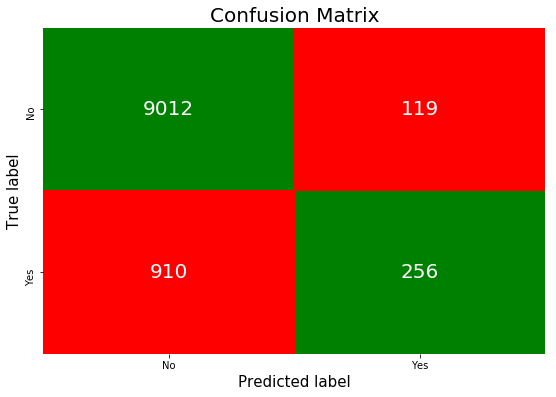

In [276]:
plot_conf_matrix(cm)

In [277]:
from mlxtend.plotting import plot_learning_curves

In [278]:
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, random_state = 4)

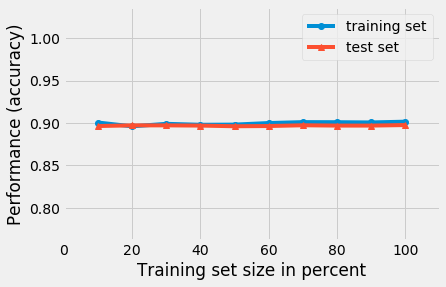

In [279]:
errors = plot_learning_curves(X_t, y_t, X_v, y_v, best_sclf, 
                    scoring = 'accuracy', print_model=False)

In [280]:
from mlxtend.evaluate import lift_score

In [281]:
print("Lift Score for Stacking Classifier:")
lift_score(y_test, best_sclf.predict(X_test))

Lift Score for Stacking Classifier:


5.949829610857588

In [282]:
from sklearn.metrics import make_scorer
lift_scorer = make_scorer(lift_score)

In [283]:
#Overriding method to grid search for custom lift scorer:
def gridSearch_clf(clf, param_grid, X_train, y_train):
    gs = GridSearchCV(clf, param_grid, scoring=lift_scorer).fit(X_train, y_train)
    print("Best Parameters")
    print(gs.best_params_)
    return gs.best_estimator_

In [284]:
best_sclf = gridSearch_clf(sclf, param_grid, X_train, y_train)
gs_report(y_test,X_test, best_sclf)

Best Parameters
{'meta-logisticregression__C': 0.01}
             precision    recall  f1-score   support

          0       0.91      0.99      0.95      9131
          1       0.68      0.22      0.33      1166

avg / total       0.88      0.90      0.88     10297

Overall Accuracy Score: 
0.9000679809653297


Tuning for lift yields the same Best Parameter as before and thus the same model

In [285]:
y_pred = best_sclf.predict(X_test)
print("Lift Score for Stacking Classifier:")
lift_score(y_test, best_sclf.predict(X_test))

Lift Score for Stacking Classifier:


6.02866094911378

However, lift is slightly higher - this is probably due to randomness as the model is the same as before

In [286]:
recall_scorer = make_scorer(recall_score)

In [287]:
#Overriding method to grid search for recall scorer:
def gridSearch_clf(clf, param_grid, X_train, y_train):
    gs = GridSearchCV(clf, param_grid, scoring=recall_scorer).fit(X_train, y_train)
    print("Best Parameters")
    print(gs.best_params_)
    return gs.best_estimator_

In [288]:
best_sclf = gridSearch_clf(sclf, param_grid, X_train, y_train)
gs_report(y_test,X_test, best_sclf)

Best Parameters
{'meta-logisticregression__C': 0.1}
             precision    recall  f1-score   support

          0       0.91      0.99      0.95      9131
          1       0.68      0.22      0.33      1166

avg / total       0.88      0.90      0.88     10297

Overall Accuracy Score: 
0.9000679809653297
